# Getting the data


In [243]:
!git clone https://github.com/Kolo-Naukowe-Data-Science-PW/Rekrutacja_2023.git

fatal: destination path 'Rekrutacja_2023' already exists and is not an empty directory.


In [244]:
!cd Rekrutacja_2023/spaceship_titanic/

# Exploratory analysis

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns

In [246]:
df = pd.read_csv("/content/Rekrutacja_2023/spaceship_titanic/dane.csv")
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Some basics about the data to get us started.

In [247]:
print(df.describe(), df.corr(numeric_only=True))
print(f"\nMissing values: \n\n{df.isna().sum()}")
print(f"\nDuplicates: \n\n{df.duplicated().sum()}")
print(f"\nNum of unique features per category: \n\n{df.nunique()}")
print(f"\nData types: {df.dtypes}")

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000                      Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000   

Notes:
- Based on count, we can safely say, that some values are missing (we see exactly which ones in the 'missing values' section)
- PassengerId is the only feature with all values intact
- Some feature engineering is most likely needed before training a model, since number of unique features differs wildly
- We have categorical features (e. g. VIP), qualitative features (e. g. name) and continuous features (e. g. Age) in our data, that has to be taken into account when exploring the data

Text(0.5, 1.0, 'Target distribution')

<Figure size 500x500 with 0 Axes>

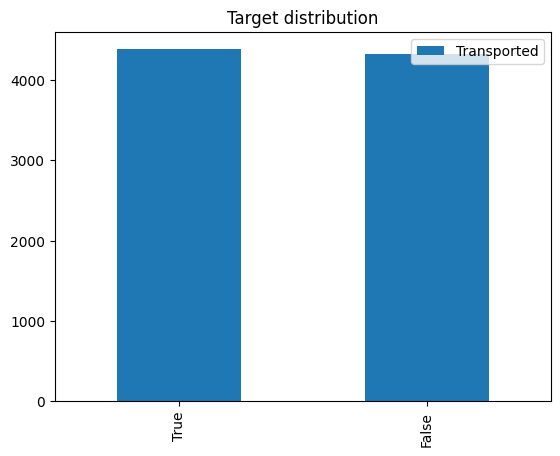

In [248]:
plt.figure(figsize=(5, 5))

# df[['Transported']].value_counts().plot.pie(autopct='%1.1f%%',).set_title("Target distribution") # Pie plot shows

df[['Transported']].apply(pd.value_counts).plot.bar().set_title("Target distribution")

As we see, target values are (almost) perfectly balanced. That's good! It saves us from having to over or undersample the dataset.


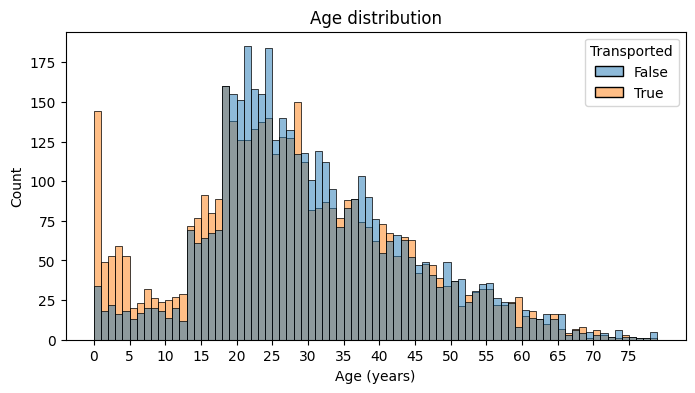

In [249]:
plt.figure(figsize=(8,4))

# Histogram, since we want to see the distribution of the target over a continuous value (age)
sns.histplot(data=df, x='Age', hue='Transported', binwidth=1)
plt.title('Age distribution')
plt.xlabel('Age (years)')
plt.xticks(range(0, 80, 5))

plt.show()

Important to note: **Age** matters a lot.
People < 18 yo where more likely to be transported than not.
People between 18 and 25 yo where more likely not to be transported.
For people > 25 yo the chances for transportation are about even. We can create a feature that reflects that (e. g. child/young adult/adult)

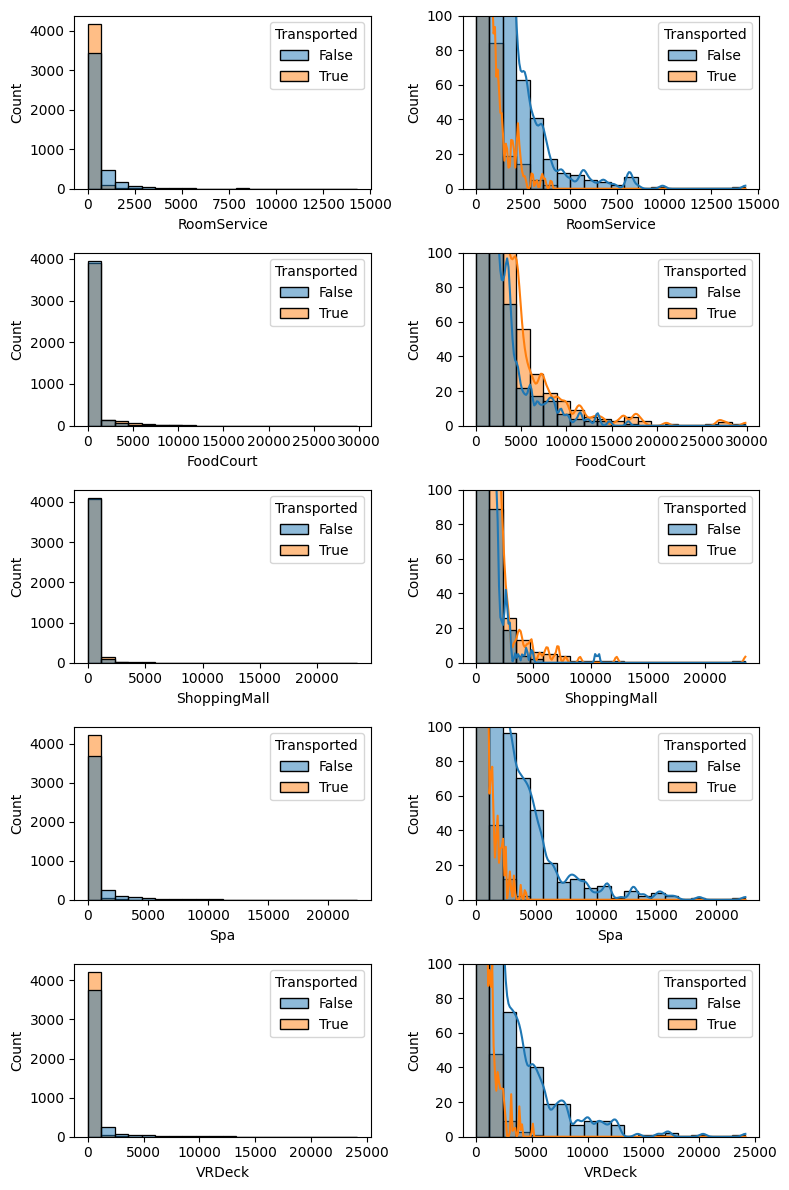

In [250]:
spending_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot spending features
fig = plt.figure(figsize=(8,12))
for i, var_name in enumerate(spending_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=df, x=var_name, axes=ax, bins=20, hue='Transported')

    # Right plot (close up)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=df, x=var_name, axes=ax, bins=20, hue='Transported', kde=True)
    plt.ylim([0,100])

fig.tight_layout()
plt.show()

Note: Most people didn't spend any (or very little) money. Those who spent little money, where more likely to be transported than those who spent a lot. There are also very few outliers (e. g. people who spent above 20000 somewhere).

We have only 4 categorical features, so lets plot them all at once.

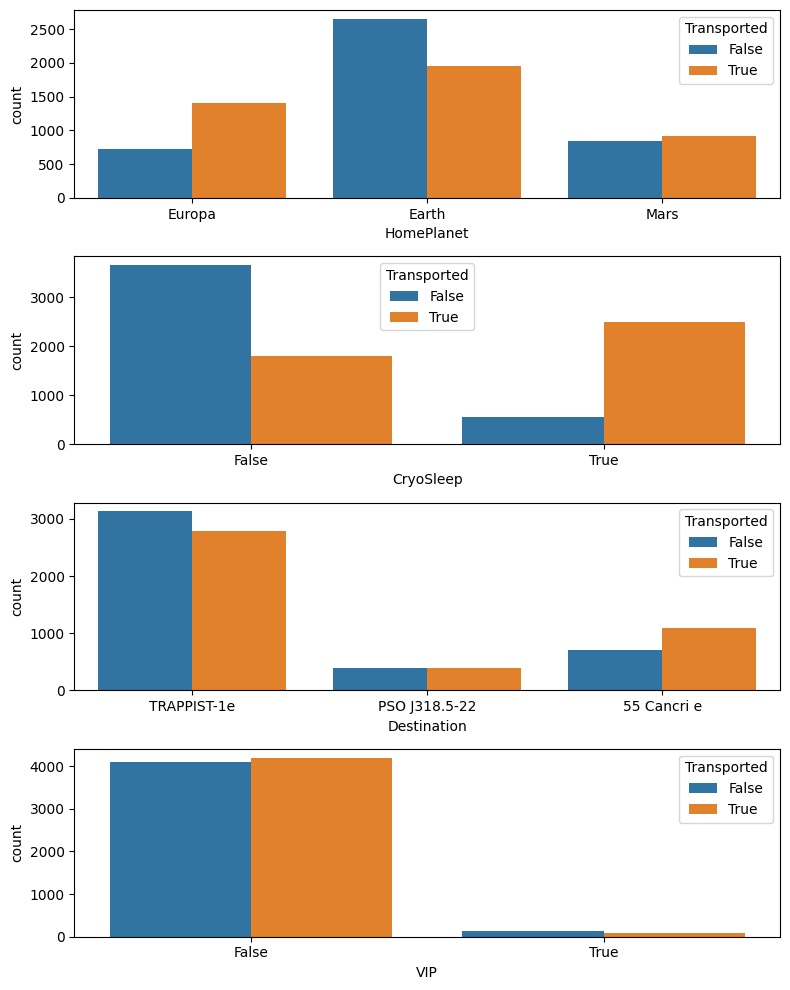

In [251]:
categorical_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize=(8,10))
for i, var_name in enumerate(categorical_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=df, x=var_name, axes=ax, hue='Transported')
fig.tight_layout()
plt.show()

Notes: Number of categories ranges from 2 to 4. Some of those features are very unbalanced and can be safely removed (mostly I refer to the **VIP** feature, which is extremely biased, leading to possible overfitting, and for which target spread is very balanced). **CryoSleep** seems to be the most useful feature out of these as depending on its values we can tell a lot about probability of transportation.

Next we have to deal with **Name**, **PassengerId** and **Cabin** number features. The problem with those is that there is a lot of them, and a lot of them are unique, which makes imputing missing values (or plotting them) quite hard.

In [252]:
qualitative_feat = ['Name', 'PassengerId', 'Cabin']
df[qualitative_feat].head(10)

,Name,PassengerId,Cabin
0,Maham Ofracculy,0001_01,B/0/P
1,Juanna Vines,0002_01,F/0/S
2,Altark Susent,0003_01,A/0/S
3,Solam Susent,0003_02,A/0/S
4,Willy Santantines,0004_01,F/1/S
5,Sandie Hinetthews,0005_01,F/0/P
6,Billex Jacostaffey,0006_01,F/2/S
7,Candra Jacostaffey,0006_02,G/0/S
8,Andona Beston,0007_01,F/3/S
9,Erraiam Flatic,0008_01,B/1/P


Notes:
- It seems **PassengerId** is formated as a set of two numbers: xxxx_yy
We can safely assume that this represents some group of passengers, which can have one (as in index 0) or more (as in indices 2 and 3) members.
- **Cabin** describes the place where a given passenger is boarded so probably sth like:
A/N/S, where A - area where the cabin is located, N - number of the cabin, S - side(given its a ship, even if a spacefaring one, P probably stands for port and S for starboard)
- **Name** is unique for each passenger (since there are no duplicates), but surnames can be the same, which in this case more likely than not means that people with the same surname are a family. Also, it seems families may be in the same group, as evidenced by rows 2 and 3.

Lets add some features that we can derive from those qualitative features.

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



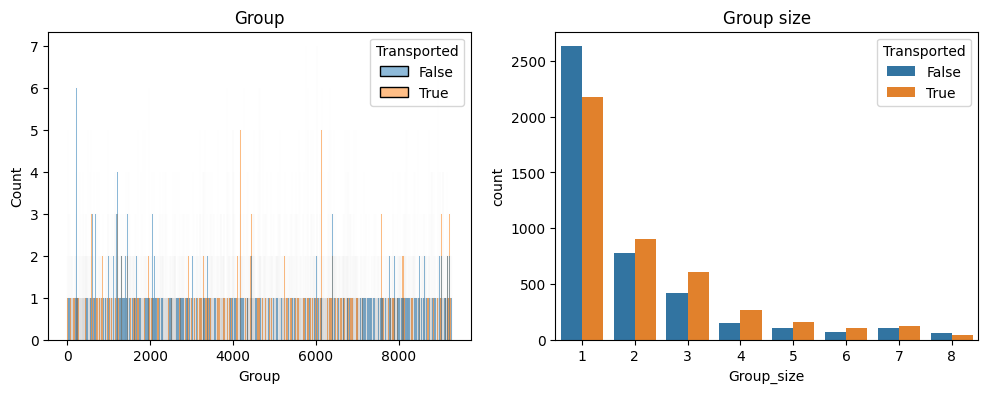

In [253]:
# New feature - Group
df['Group'] =  df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
df['Group_size'] = df['Group'].map(lambda x: df['Group'].value_counts()[x])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=df, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

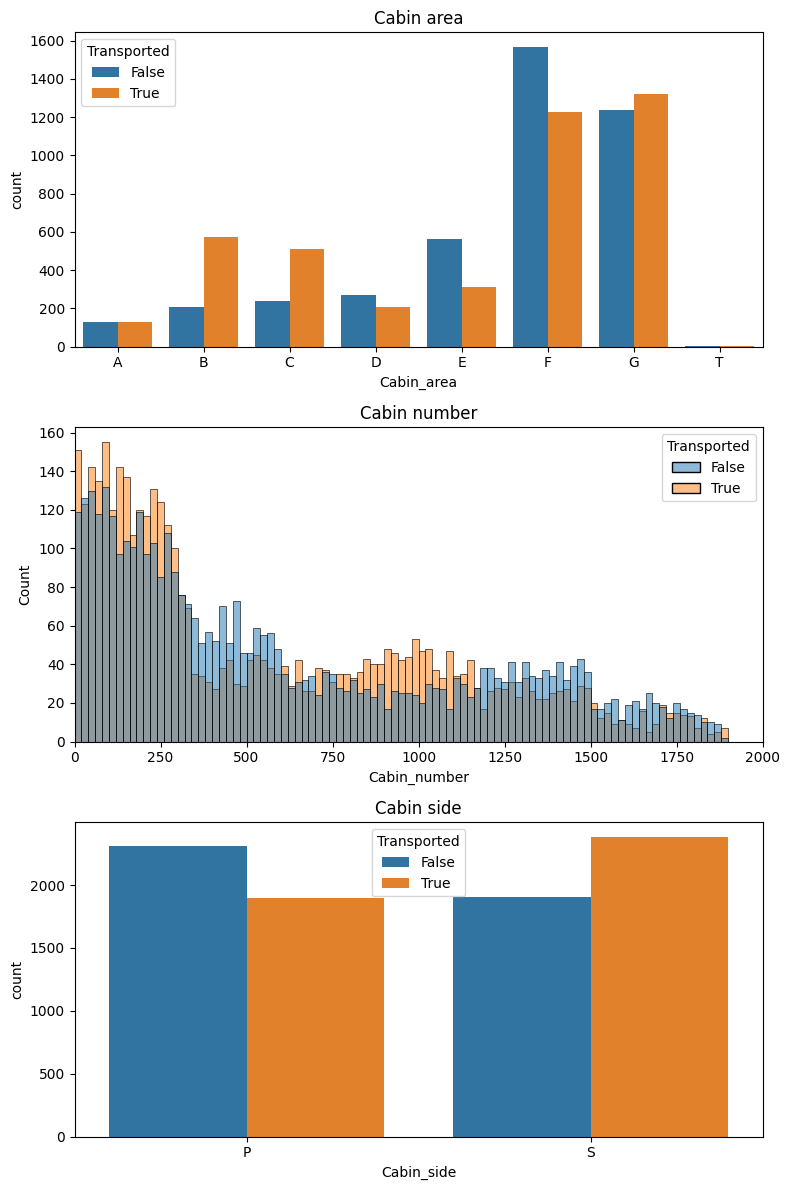

In [254]:
df['Cabin'].fillna('Z/9999/Z', inplace=True) # fill missing values with outliers for now, so we can apply split

# New features - cabin area, number and side
df['Cabin_area'] = df['Cabin'].apply(lambda x: x.split('/')[0])
df['Cabin_number'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
df['Cabin_side'] = df['Cabin'].apply(lambda x: x.split('/')[2])

df.loc[df['Cabin_area']=='Z', 'Cabin_area'] = np.nan
df.loc[df['Cabin_number']==9999, 'Cabin_number'] = np.nan
df.loc[df['Cabin_side']=='Z', 'Cabin_side'] = np.nan

df.drop('Cabin', axis=1, inplace=True) # All info already extracted from cabin

fig=plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
sns.countplot(data=df, x='Cabin_area', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin area')

plt.subplot(3,1,2)
sns.histplot(data=df, x='Cabin_number', hue='Transported', binwidth=20)
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=df, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

In [255]:
df[df["Cabin_area"] == 'T'].loc[:, "Cabin_area"]

1004    T
2254    T
2734    T
2763    T
4565    T
Name: Cabin_area, dtype: object

Notes: Area T seems to be the outlier here (there are only 5 rows with that value). Additionaly, there is an interesting correlation with cabin numbers - they seem to be divided into certain 'sections', where people from some sections are much more likely to be transported than those from others.

(0.0, 2000.0)

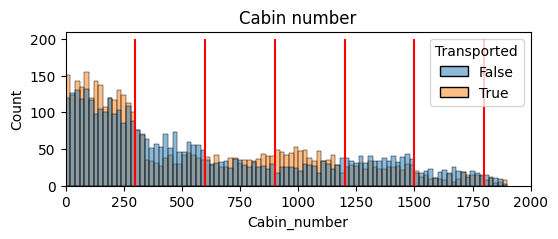

In [256]:
plt.figure(figsize=(6, 2))
sns.histplot(data=df, x='Cabin_number', hue='Transported', binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='red')
plt.vlines(600, ymin=0, ymax=200, color='red')
plt.vlines(900, ymin=0, ymax=200, color='red')
plt.vlines(1200, ymin=0, ymax=200, color='red')
plt.vlines(1500, ymin=0, ymax=200, color='red')
plt.vlines(1800, ymin=0, ymax=200, color='red')
plt.title('Cabin number')
plt.xlim([0,2000])

If that's the case it would be a good idea to change this feature into a categorical one. Lastly, we can find out the size of families that are on board, based on a surname (or at least have a good estimation).

Text(0.5, 1.0, 'Family size')

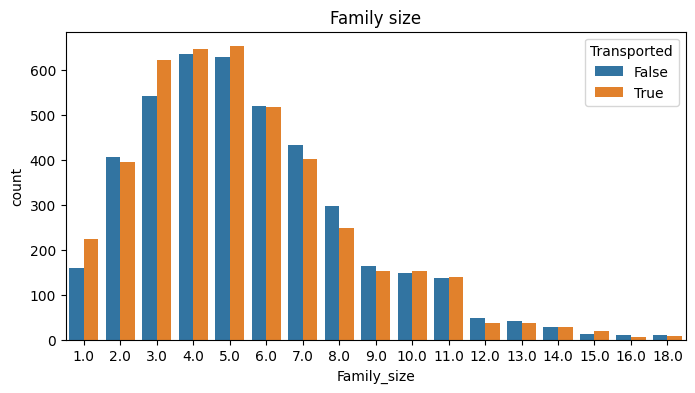

In [257]:
# Replace missing values with outliers for now (so we can split feature)
df['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname (it's better than name, because it has less unique values)
df['Surname'] = df['Name'].str.split().str[-1]

# New feature - Family size
df['Family_size'] = df['Surname'].map(lambda x: df['Surname'].value_counts()[x])

# Put missing values back in
df.loc[df['Surname'] == 'Unknown','Surname'] = np.nan
df.loc[df['Family_size'] > 100,'Family_size'] = np.nan   # If family is bigger than 100, it's probably an outlier anyways, and unknows get eliminated

# Drop name (we don't need it anymore)
df.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Family_size', hue='Transported')
plt.title('Family size')

Notes: 18 is a little big for a family, but lets leave it like that for now

# Feature engineering


First, lets create an age group distribution, which we figured out may be useful in data analysis.

Text(0.5, 1.0, 'Age group distribution')

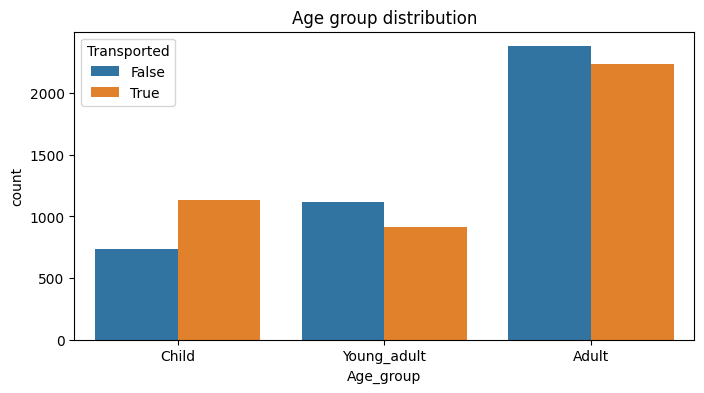

In [258]:
df['Child'] = df['Age'] <= 18
df['Young_adult'] = df['Age'] <= 25
df['Adult'] = df['Age'] > 25

df['Age_group'] = np.nan
df.loc[df['Child'] == True, 'Age_group'] = "Child"
df.loc[(df['Young_adult'] == True) & (df['Child'] == False), 'Age_group'] = "Young_adult" # Young_adult is an imperfect metric, so we have to account for that
df.loc[df['Adult'] == True, 'Age_group'] = "Adult"

df.drop(['Child', 'Young_adult', 'Adult'], axis=1, inplace=True)

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Age_group', hue='Transported', order=['Child', 'Young_adult', 'Adult'])
plt.title('Age group distribution')

Second, lets group spending features together and create a feature that whether a person spent anything at all.

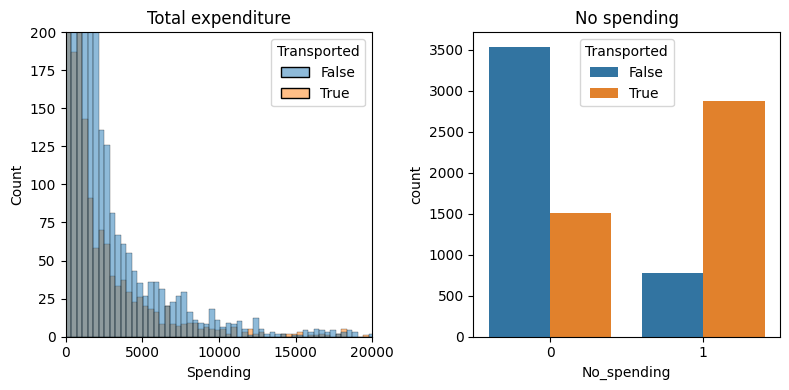

In [259]:
df['Spending'] = df[spending_feats].sum(axis=1)
df['No_spending'] = (df['Spending'] == 0).astype(int)

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='Spending', hue='Transported', bins=100)
plt.title('Total expenditure')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=df, x='No_spending', hue='Transported')
plt.title('No spending')
fig.tight_layout()

Third, lets create categorical features for cabin regions, which we figured out could be useful.

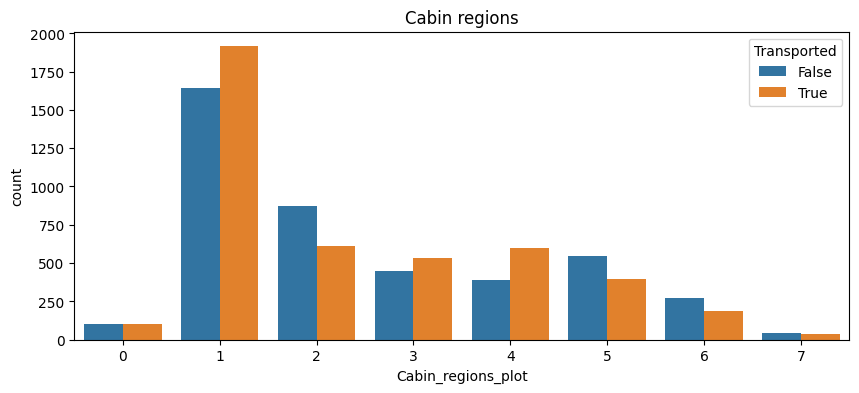

In [260]:
# New features - training set
df['Cabin_region1'] = (df['Cabin_number'] < 300).astype(int)   # one-hot encoding
df['Cabin_region2'] = ((df['Cabin_number'] >= 300) & (df['Cabin_number'] < 600)).astype(int)
df['Cabin_region3'] = ((df['Cabin_number'] >= 600) & (df['Cabin_number'] < 900)).astype(int)
df['Cabin_region4'] = ((df['Cabin_number'] >= 900) & (df['Cabin_number'] < 1200)).astype(int)
df['Cabin_region5'] = ((df['Cabin_number'] >= 1200) & (df['Cabin_number'] < 1500)).astype(int)
df['Cabin_region6'] = ((df['Cabin_number'] >= 1500) & (df['Cabin_number'] < 1800)).astype(int)
df['Cabin_region7'] = (df['Cabin_number'] >= 1800).astype(int)

plt.figure(figsize=(10,4))
df['Cabin_regions_plot'] = (df['Cabin_region1']+2*df['Cabin_region2']+3*df['Cabin_region3']+4*df['Cabin_region4']+5*df['Cabin_region5']+6*df['Cabin_region6']+7*df['Cabin_region7']).astype(int)
sns.countplot(data=df, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
df.drop('Cabin_regions_plot', axis=1, inplace=True)

And lastly, lets drop the **VIP** feature.

In [261]:
df.drop('VIP', axis=1, inplace=True)

# Missing values

We have to deal with missing values somehow, if we want to train a model on them. Can we just drop them? Lets see a heatmap to find out what is the distribution of the missing values.

Text(0.5, 1.0, 'Heatmap of missing values')

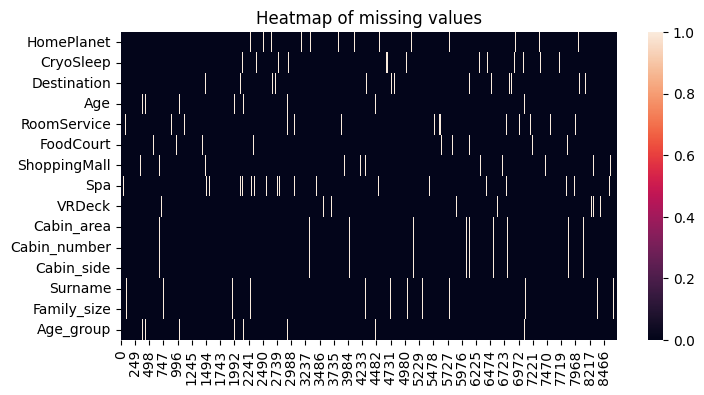

In [262]:
missing = df.columns[df.isna().any()].tolist()

summary = pd.DataFrame(df[missing].isna().sum(), columns=["Num of missing"])

plt.figure(figsize=(8, 4))
sns.heatmap(df[missing].isna().T)
plt.title("Heatmap of missing values")

In [263]:
print(f"Entries with missing values: {df.isna().sum().sum()}\n% of dataset entries with missing values: {(df.isna().sum().sum()/len(df)*100).round(2)}%")

Entries with missing values: 2898
% of dataset entries with missing values: 33.34%


Notes: The distribution of the missing values is spread fairly evenly in the data. Also, there are nearly 3000 rows of data with a value missing in at least one of the features. That's over 1//3 of our dataset! As such, it would be better not to drop the rows with missing values, but rather fill them. One way of filling the NaN's is by taking a median value of all other values. A better one is to find some relationships between the values, but lets try to train out model on the easier version first and if the accuracy will be low, we will change our approach.

In [319]:
# Labels and features
y = df['Transported'].copy().astype(int)
X = df.drop('Transported', axis=1).copy()

In [320]:
X.isna().sum()

PassengerId        0
HomePlanet       201
CryoSleep        217
Destination      182
Age              179
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Group              0
Group_size         0
Cabin_area       199
Cabin_number     199
Cabin_side       199
Surname          200
Family_size      200
Age_group        179
Spending           0
No_spending        0
Cabin_region1      0
Cabin_region2      0
Cabin_region3      0
Cabin_region4      0
Cabin_region5      0
Cabin_region6      0
Cabin_region7      0
dtype: int64

In [321]:
# What kind of data are we missing?
cat = [col for col in missing if X[col].dtype == 'object']
num = [col for col in missing if X[col].dtype in ['float64', 'int64']]
cat, num

(['HomePlanet',
  'CryoSleep',
  'Destination',
  'Cabin_area',
  'Cabin_side',
  'Surname',
  'Age_group'],
 ['Age',
  'RoomService',
  'FoodCourt',
  'ShoppingMall',
  'Spa',
  'VRDeck',
  'Cabin_number',
  'Family_size'])

In [322]:
# Impute values by: categorical - mode, continuous - median, qualitative - outliers
[X[col].fillna(X[col].median(), inplace=True) for col in num]
[X[col].fillna(X[col].mode()[0], inplace=True) for col in cat]
X.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Group            0
Group_size       0
Cabin_area       0
Cabin_number     0
Cabin_side       0
Surname          0
Family_size      0
Age_group        0
Spending         0
No_spending      0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
dtype: int64

Note: we do not have any qualitative features we're gonna use for training here, so we can ommit outlier imputing.

# Preprocessing

In [323]:
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number', 'Surname'], axis=1, inplace=True)

In [324]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Spending']:
    X[col]=np.log(1+X[col])

In [270]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [325]:
cat = [col for col in X.columns if X[col].dtype == 'object']
num = [col for col in X.columns if X[col].dtype in ['float64', 'int64']]

# Scale continuous values
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse_output=False))])

# Combine preprocessing (num and cat are our categorized columns from Missing Values section)
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num),
        ('cat', categorical_transformer, cat)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 33)


Now, lets do some Principle Component Analysis, just for fun!

In [326]:
import plotly.express as pe

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = pe.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height=500
)
fig.show()

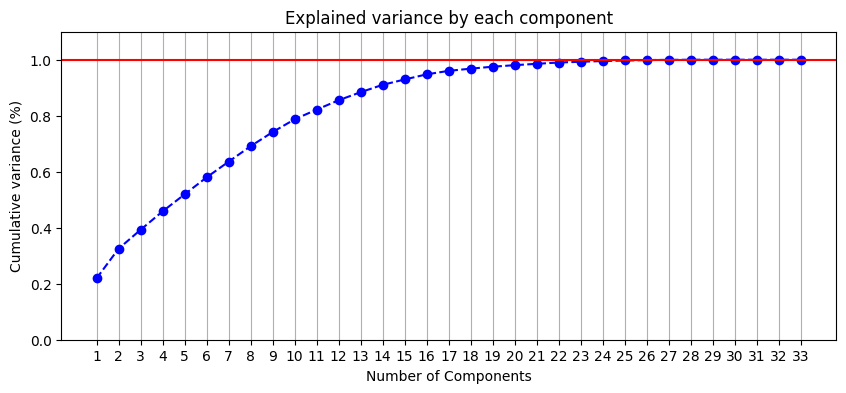

In [327]:
# Explained variance (how important each additional principal component is)
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
ax.grid(axis='x')

# Model selection & Training

At this point we can start learning with out model. Normally, for a task including tabular data such as this one, we would use a shallow algorithm, something akin to Logistic Regression, Naive Bayes, Random Forest or Gradient Boosters. That being said, this approach is kinda... boring. Thus, we're gonna train a neural network!

For this to work well (relatively), it would be best to scale our values to between 0 and 1, as that is the preferred input format for neural networks.

In [328]:
from sklearn.preprocessing import MinMaxScaler

scaler  = MinMaxScaler()

X = scaler.fit_transform(X)

In [329]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0)

Now, we create a neural network.
*Update: added dropout for regularization (model was slightly overfitting)*

In [275]:
from tensorflow import keras

In [330]:
model = keras.Sequential(
    [
        keras.layers.Dense(units=9, activation="relu", input_shape=(X.shape[-1],) ),
        # randomly delete 30% of the input units below
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=9, activation="relu"),
        # the output layer, with a single neuron
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

# save the initial weights for later
initial_weights = model.get_weights()

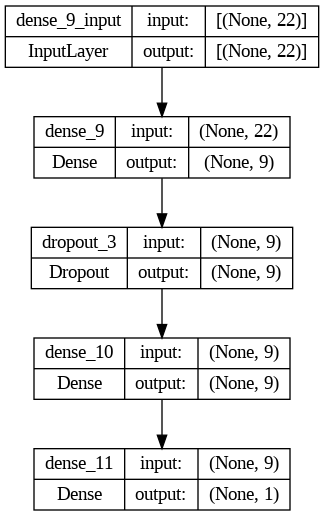

In [277]:
keras.utils.plot_model(model, show_shapes=True)

Using Adam as optimizer here, with binary_accuracy, might change that later. *Update: Also adding early stopping callback, to reduce overfitting*

In [331]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=[keras.metrics.binary_accuracy, keras.metrics.AUC()]
             )

In [332]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.0002,
    patience  = 20,
    restore_best_weights=True,
)

And finally - training

In [333]:
model.set_weights(initial_weights)    # This is here only for resetting the training phase

In [ ]:
history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=100,
          validation_data=(X_val, y_val),
          verbose=0,                        # Set to 1 if updates about training state are needed
          callbacks=[early_stopping]
          )

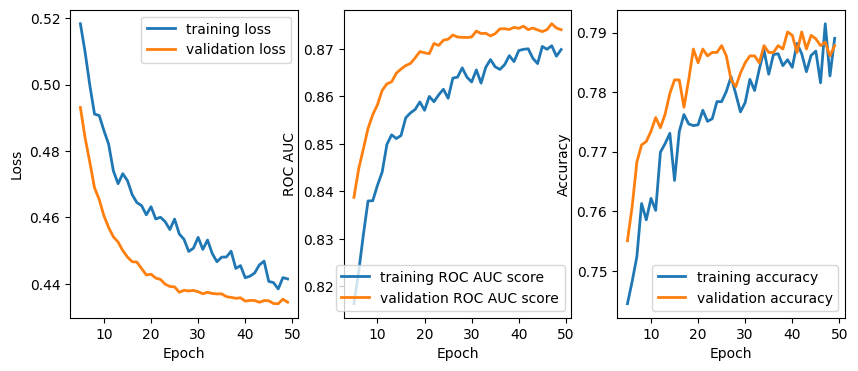

In [335]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(logs.iloc[5:, 2], lw=2, label='training ROC AUC score')
plt.plot(logs.iloc[5:, 5], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.subplot(1, 3, 3)
plt.plot(logs.loc[5:,"binary_accuracy"], lw=2, label='training accuracy')
plt.plot(logs.loc[5:,"val_binary_accuracy"], lw=2, label='validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The model was slightly overfitting at the beginning, so adding dropout and early stopping callback was necessary. That being said, final metrics can be seen above and for a neural network operating on a tabular data, they are not half bad. Validation accuracy is dropping at the end of the training, but AUC score is rising steadily and loss is decreasing, so the model is fairly successful.